### Example of using NWayMatch

MultiMatch is the current default Multi-catalog matcher in the Rubin DM stack.  It performs a series
of two-way catalog matches, updating the reference catalog as it goes.

NWayMatch is a simple proof-of-concept for multi-catalog matching.
Rather than do a series of 2-way matches, it clusters sources and then resolves
the cluster membership to ensure that each input catalog only contributes at most
one source to any given "object".

This example assumes that you:

    1. Have downloaded the data here:  https://lsst.ncsa.illinois.edu/~yusra/nway-matcher/
    2. Are running from the directory you download the data into.
    3. Have run MultiMatch on those data for comparison (using multiMatch.py to generate matchCat.fits)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import glob
import os
import numpy as np
from nway import NWayMatch

### Define the inputs and the parameters for the map used to cluster the sources

In [3]:
DATADIR = "."
SOURCE_TABLEFILES = glob.glob(os.path.join(DATADIR, "sourceTable-00*.parq"))
VISIT_IDS = np.arange(len(SOURCE_TABLEFILES))

REF_DIR = (150., 2.)   # RA, DEC in deg
REGION_SIZE = (3., 3.) # in Deg
CELL_SIZE = 1. / (3600*2) # in Deg = 0.5"
SUBREGION_SIZE = 1350 # in Pixels
PIXEL_R2CUT = 1.

### Construct a matcher object

This will construct at WCS to grid a 3deg x 3deg region around ra=150, dec=2 at 5e-5 deg resolution

It will also define a set of 1350 cell x 1350 cell sub-regions that will be analyzed independently

In [4]:
nWay = NWayMatch.create(REF_DIR, REGION_SIZE, CELL_SIZE, pixelR2Cut=PIXEL_R2CUT, subRegionSize=SUBREGION_SIZE)
print(nWay.nSubRegion)

[16. 16.]


### Reduce the input data

This will project the input data into the WCS constructed above

In [5]:
nWay.reduceData(SOURCE_TABLEFILES, VISIT_IDS)

### Analyze one of the sub-regions

In [6]:
oDict = nWay.analyzeSubregion(10, 10, True)

In [7]:
srd = oDict['srd']
cd = srd._clusterDict
idx = 17009734
image = oDict['image']
cluster = cd[idx]

In [8]:
srcIdx = np.hstack([df['sourceId'] for df in srd._data])

### This function will draw a cluster

The background image is the pixels used to do the cluster, the color scale 
shows the number of sources per pixel

The blue dots in the foreground are the positions of the individual sources

The red cross is the cluster centroid

In [9]:
def showCluster(img, cluster, srd, mask=None):
    extent = (0, cluster._footprint.getBBox().getWidth(),
              0, cluster._footprint.getBBox().getHeight())
    cluster.extract(srd)
    xOffset = srd._minCell[0] + cluster._footprint.getBBox().getBeginY()
    yOffset = srd._minCell[1] + cluster._footprint.getBBox().getBeginX()
    xOff = cluster.xCell - xOffset
    yOff = cluster.yCell - yOffset
    if mask is not None:
        xOff = xOff[mask]
        yOff = yOff[mask]
    xC = cluster._xCent - xOffset
    yC = cluster._yCent - yOffset
    img = plt.imshow(image[cluster._footprint.getBBox()].array, origin='lower', extent=extent)
    cb = plt.colorbar()
    img.axes.scatter(yOff, xOff)
    img.axes.scatter(yC, xC, marker='+', c='green')
    return img.axes.figure

### This function will draw a cluster and show the objects

Same as above, expect the dots are color-coded to show how the cluster way broken down

In [10]:
def showObjects(img, cluster, srd):
    extent = (0, cluster._footprint.getBBox().getWidth(),
              0, cluster._footprint.getBBox().getHeight())
    cluster.extract(srd)
    xOffset = srd._minCell[0] + cluster._footprint.getBBox().getBeginY()
    yOffset = srd._minCell[1] + cluster._footprint.getBBox().getBeginX()
    xOff = cluster.xCell - xOffset
    yOff = cluster.yCell - yOffset
    img = plt.imshow(image[cluster._footprint.getBBox()].array, origin='lower', extent=extent)
    cb = plt.colorbar()
    colors = ['red', 'blue', 'green', 'cyan', 'orange', 'grey']
    for iObj, obj in enumerate(cluster.objects):
        xC = obj._xCent - xOffset
        yC = obj._yCent - yOffset
        img.axes.scatter(yOff[obj._mask], xOff[obj._mask], c=colors[iObj%6])
        img.axes.scatter(yC, xC, marker='+', c=colors[iObj % 6])
    return img.axes.figure

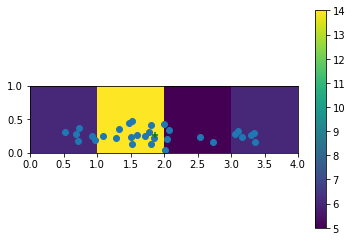

In [11]:
fig = showCluster(image, cluster, srd)

#### Pull out the ids of clusters of particular types

split -> at least one of the input catalogs seems to have split the source

singleCell -> all the sources are in a single cell

confused -> there are multiple sources from many input catalogs

In [12]:
split = []
for k, c in cd.items():
    if c._nSrc == c._nUnique + 1:
        split.append(k)

In [13]:
confused = []
for k, c in cd.items():
    if c._nSrc > c._nUnique + 4:
        confused.append(k)

In [14]:
singleCell = []
for k, c in cd.items():
    if c._nSrc > 5 and c._footprint.getArea() == 1:
        singleCell.append(k)

In [27]:
twoCell = []
for k, c in cd.items():
    if c._nSrc > 5 and c._footprint.getArea() == 2:
        twoCell.append(k)

### Draw different types of clusters

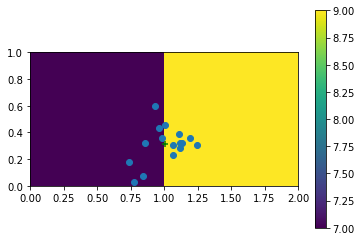

In [31]:
figTwoCell = showCluster(image, cd[twoCell[2]], srd)

#### This is a simple split cluster

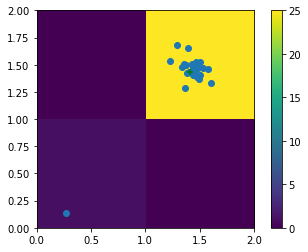

In [15]:
fig2 = showCluster(image, cd[split[4]], srd)

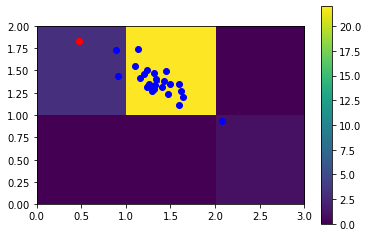

In [16]:
fig2_o = showObjects(image, cd[split[6]], srd)

#### This is an ideal cluster, where all the sources are in a single cell

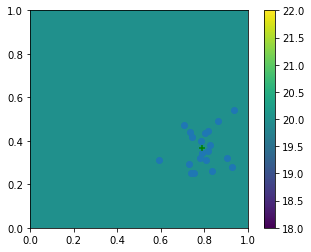

In [17]:
fig3 = showCluster(image, cd[singleCell[0]], srd)

#### This is a very confused cluster; several input catalog contribute more than one source

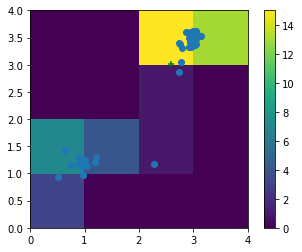

In [40]:
fig4 = showCluster(image, cd[confused[7]], srd)

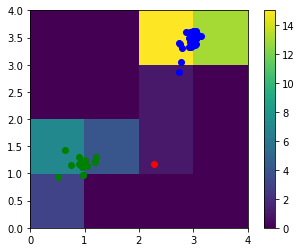

In [41]:
fig4_o = showObjects(image, cd[confused[7]], srd)

#### These are some functions to get assocations from the MulitMatch matching catalog

In [20]:
def getObjectId(assocTable, srcId, idField='id', objField='object'):
    mask = assocTable[idField] == srcId
    return assocTable[mask][objField].data

In [21]:
def getSourceIds(assocTable, objId, idField='id', objField='object'):
    mask = assocTable[objField] == objId
    return assocTable[mask][idField].data

In [22]:
def getAssociatedSources(cluster, assocTable, idField='id', objField='object'):
    matchObjs = np.unique(np.hstack([getObjectId(mAssoc, sId) for sId in cluster._sourceIds]))
    sIds = [getSourceIds(assocTable, matchObj) for matchObj in matchObjs]
    return sIds

In [23]:
def showAssociatedObjects(img, cluster, srd, assocTable):
    extent = (0, cluster._footprint.getBBox().getWidth(),
              0, cluster._footprint.getBBox().getHeight())
    cluster.extract(srd)
    xOffset = srd._minCell[0] + cluster._footprint.getBBox().getBeginY()
    yOffset = srd._minCell[1] + cluster._footprint.getBBox().getBeginX()
    xOff = cluster.xCell - xOffset
    yOff = cluster.yCell - yOffset
    img = plt.imshow(image[cluster._footprint.getBBox()].array, origin='lower', extent=extent)
    cb = plt.colorbar()
    colors = ['red', 'blue', 'green', 'cyan', 'orange', 'grey']
    sIds = getAssociatedSources(cluster, mAssoc)
    for iObj, obj in enumerate(sIds):
        mask = np.in1d(cluster._sourceIds, obj)
        img.axes.scatter(yOff[mask], xOff[mask], c=colors[iObj%6])
    return img.axes.figure

#### Read the multimatch matching catalog

In [24]:
from astropy.table import Table
mAssoc = Table.read('matchCat.fits')

#### Compare results

Here we show the results of the NWayMatch and then we take all of the input sources add look for associations in the
MultiMatch catalog.  Note that many of the sources do not have any matches in the MultiMatch catalog.  This is b/c the "ambiguous" sources are being removed. 

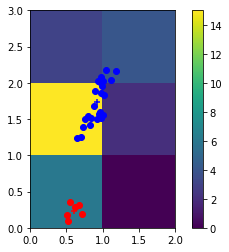

In [25]:
fig5_o = showObjects(image, cd[confused[7]], srd)

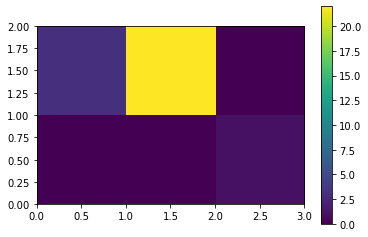

In [43]:
fig5_o = showAssociatedObjects(image, cd[split[6]], srd, mAssoc)